https://pymc3.readthedocs.io/en/latest/notebooks/getting_started.html#Model-Specification

In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# Generating data

In [4]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

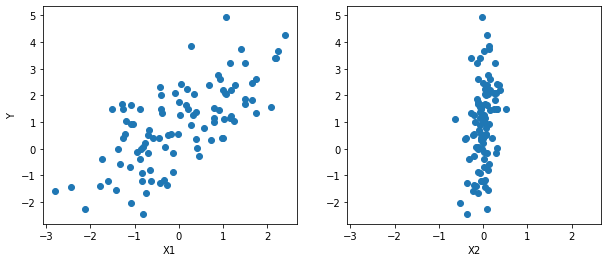

In [5]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

# Model Specification

Priors : 과거의 믿음

Likelihood

Model : 모든 pymc3의 변수가 저장됨

In [6]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters, 
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

### pm.Normal
 - pm.Normal(이름, mu=평균, sd= 표준편차)
 
 Most commonly used distributions, such as Beta, Exponential, Categorical, Gamma, Binomial and many others, are available in PyMC3.
 
### mu
- 선형 관계를 지정하여 예상값 을 만듬
- 이것은 Deterministic variable 이다.
 
### Deterministic variable

- Deterministic variable. If the outcome of a variable is fixed, i.e. if a variable will always have the exact same value, we call this a deterministic variable.

### Y_obs
- 데이터 세트에서 결과의 샘플링 분포를 정의
- likelihood
- observed 값을 넣어야함

# Model fitting


## 1) MAP 방법
모델에 대한 최대 사후 추정 (Maximum a posteriori methods, MAP) 

MAP으로 추출한 샘플을 기반으로 요약을 계산한다. (MCMC) 샘플링 방법.

In [7]:
map_estimate = pm.find_MAP(model=basic_model)

map_estimate

C:\Users\jsh\Anaconda3\envs\tens2\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -149.58, ||grad|| = 12.242: 100%|██████████| 19/19 [00:00<00:00, 2381.35it/s]  


{'alpha': array(0.90660093),
 'beta': array([0.94848596, 2.60711845]),
 'sigma_log__': array(-0.03771373),
 'sigma': array(0.96298858)}

기본적으로 find_MAPBFGS (Broyden-Fletcher-Goldfarb-Shanno) 최적화 알고리즘을 사용하여 로그 후방 최대 값을 찾지 만 scipy.optimize모듈 에서 다른 최적화 알고리즘을 선택할 수도 있습니다 . 예를 들어 아래에서는 Powell의 방법을 사용하여 MAP을 찾습니다.

In [8]:
from scipy import optimize

map_estimate = pm.find_MAP(model=basic_model, fmin=optimize.fmin_powell)

map_estimate

C:\Users\jsh\Anaconda3\envs\tens2\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
C:\Users\jsh\Anaconda3\envs\tens2\lib\site-packages\pymc3\tuning\starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '
logp = -149.47:   3%|▎         | 170/5000 [00:00<00:00, 7747.99it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176


{'alpha': array(0.90907964),
 'beta': array([0.9514399 , 2.61452795]),
 'sigma_log__': array(-0.03492212),
 'sigma': array(0.96568062)}

## 2) MCMC 방법 

- Markov Chain과 Monte Carlo라는 두가지 수학적 특성을 기반으로 샘플링을 하는 것

### sample함수

- 지정된 반복 횟수 동안 할당 된 (또는 전달 된) 메서드를 실행하고 Trace수집 된 샘플을 포함 하는 개체를 수집 된 순서대로 반환합니다 . 
- 디폴트는 : NUTS sampler
- step 파라미터를 통해 샘플러 지정 가능

In [9]:
from scipy import optimize

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]

Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1534.15draws/s]

### 샘플링 결과

샘플링하여 분포 형태로 샘플을 생성

In [11]:
trace['alpha']

array([0.81169582, 0.99498608, 0.9838332 , ..., 0.94660983, 0.8224523 ,
       0.91406583])

In [12]:
trace['beta']

array([[0.98694969, 3.16885859],
       [0.96114976, 2.76374484],
       [0.85151211, 2.78607435],
       ...,
       [0.94928116, 2.52640595],
       [0.98853556, 2.66299666],
       [0.95877914, 2.67616697]])

In [13]:
trace['sigma_log__']

array([-0.0861577 , -0.08046437,  0.01684589, ..., -0.08770973,
        0.10278038, -0.03353512])

In [14]:
trace['sigma']

array([0.91744954, 0.92268778, 1.01698858, ..., 0.91602673, 1.10824799,
       0.96702095])

### slice 샘플러를 사용한 경우

In [15]:
with basic_model:

    # obtain starting values via MAP
    start = pm.find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, start=start)

C:\Users\jsh\Anaconda3\envs\tens2\lib\site-packages\pymc3\tuning\starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
C:\Users\jsh\Anaconda3\envs\tens2\lib\site-packages\pymc3\tuning\starting.py:102: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  warnings.warn('In future versions, set the optimization algorithm with a string. '

logp = -149.47:   3%|▎         | 170/5000 [00:00<00:00, 5681.80it/s]

Optimization terminated successfully.
         Current function value: 148.984564
         Iterations: 4
         Function evaluations: 176



logp = -149.47:   4%|▎         | 176/5000 [00:00<00:01, 4199.05it/s]Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]

Sampling 4 chains: 100%|██████████| 22000/22000 [00:06<00:00, 3506.42draws/s]

In [16]:
trace['alpha']

array([0.86742633, 0.92218227, 1.02750271, ..., 1.00080546, 1.00484741,
       1.07093704])

# 분석

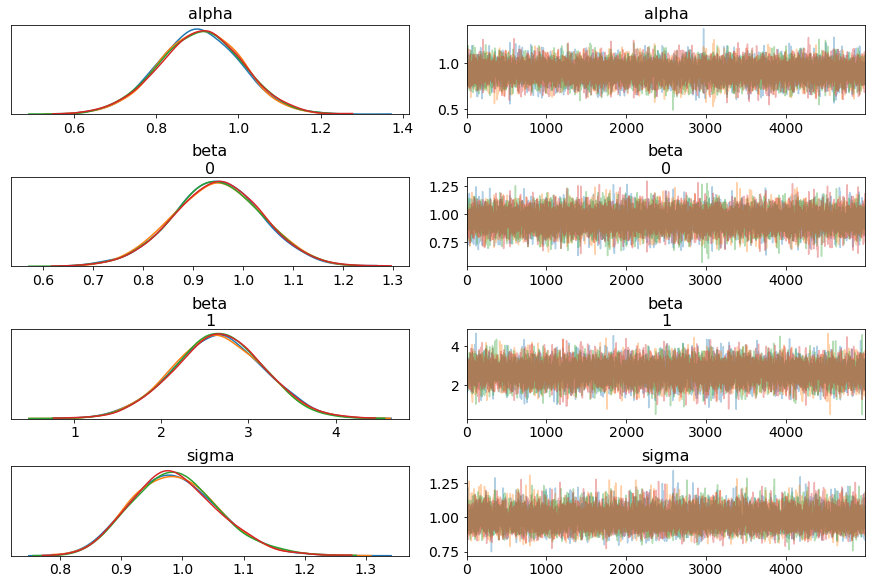

In [17]:
_ = pm.traceplot(trace)

In [18]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.907031,0.098634,0.000773,0.710799,1.099440,18925.148078,1.000070
beta__0,0.949083,0.089033,0.000589,0.773760,1.123104,19226.497865,1.000015
beta__1,2.656917,0.511899,0.004083,1.627103,3.626607,16037.041159,1.000066
sigma,0.989491,0.070823,0.000505,0.858072,1.129438,17171.684471,0.999973
